# AMAZON ALEXA SENTIMENT ANALYSIS

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
#PorterStemmer: Used to reduce words to their root form. E.g., "studying" → "studi"
nltk.download('stopwords')
#Downloads English stopwords
'''This downloads the stopwords data the first time you use it.
nltk stores language resources like word lists separately.
If you skip this, Python will throw an error saying the stopwords resource is missing.'''
#Converts list to set for faster lookup
from nltk.corpus import stopwords
STOPWORDS=set(stopwords.words('english'))
#stopwords: Common words like “the”, “is”, “and” that don’t add much meaning


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [122]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud
from xgboost import XGBRFClassifier
import pickle
import re

**Exploratory data Analysis**

In [123]:
data=pd.read_csv("/content/amazon_alexa.tsv",delimiter="\t",quoting=3)

✅ 1. delimiter="\t"
This tells pandas.read_csv() that the file is tab-separated, not comma-separated.

\t is the escape sequence for a tab character.

🔍 Why Needed?
If you don’t specify this, pandas will assume the default delimiter , (comma), and your data will get parsed incorrectly — all values will go into one column.<br
>
✅ 2. quoting=3
This comes from Python's built-in csv module:

python
Copy
Edit
quoting=3 ⇨ csv.QUOTE_NONE
🔍 What It Means:
It tells pandas not to treat anything as quoted text.

No field is wrapped in "..." or '...'.

This is usually done when:

You know your file doesn’t contain quotes around text fields.

You want to avoid pandas misinterpreting certain characters inside quotes.



In [124]:
data.shape

(3150, 5)

In [125]:
data.head(5)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [126]:
data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

Checking for null value

In [127]:
data.isnull().value_counts()

rating  date   variation  verified_reviews  feedback
False   False  False      False             False       3149
                          True              False          1
Name: count, dtype: int64

In [128]:
data.dropna(inplace=True)

data.isnull.value_counts()

In [129]:
data.shape

(3149, 5)

In [130]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64


creating a new column 'length' that will contain the length of the string in 'verified_reveiws' column

In [131]:
data['length']=data['verified_reviews'].apply(len)

In [132]:
data.head(5)

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


### Analysing the rating column

The column refers to the rating of the variation given by the user

In [133]:
data['rating'].value_counts()

,count
rating,
5,2286
4,455
1,161
3,152
2,95


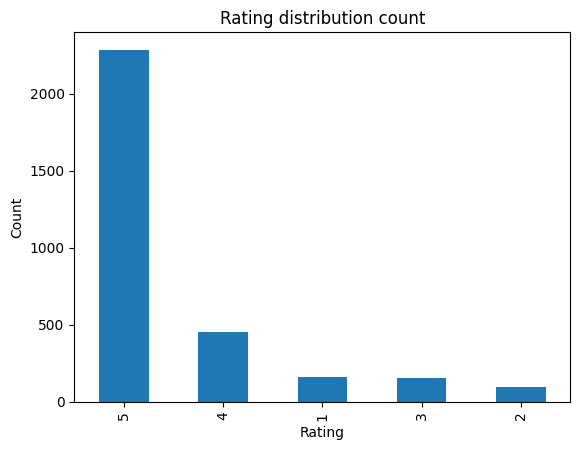

In [134]:
data['rating'].value_counts().plot(kind='bar')
plt.title('Rating distribution count')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Finding the percentage distribution of each rating

In [135]:
round(data['rating'].value_counts()/len(data)*100,2)

,count
rating,
5,72.59
4,14.45
1,5.11
3,4.83
2,3.02


So,72.59% of rating is 5

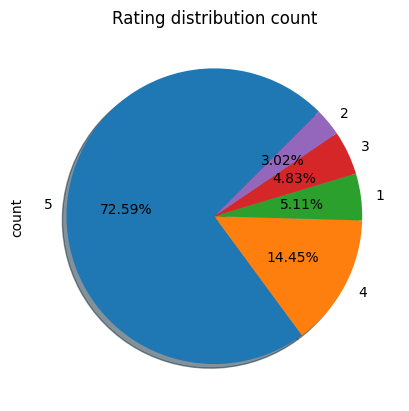

In [136]:
#Pie-plot to visualize percentage of rating
colors = ['green','orange','blue','yellow','red']
data['rating'].value_counts().plot(kind='pie',autopct='%1.2f%%',color=colors,startangle=45,shadow=True)

plt.title('Rating distribution count')
plt.show()

## Analysing feedback column

This column refers to feedback of the verified reviewer

In [137]:
data['feedback'].value_counts()

,count
feedback,
1,2893
0,256


data.head(5)

In [138]:
data.head(5)

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [139]:
# reviews where feedback is 0
negative_feedback=data[data['feedback']==0].head(5)
negative_feedback.shape

(5, 6)

thus,0 corresponds to negative review

In [140]:
positive_feedback=data[data['feedback']==1]
positive_feedback.shape

(2893, 6)

1 means positive review

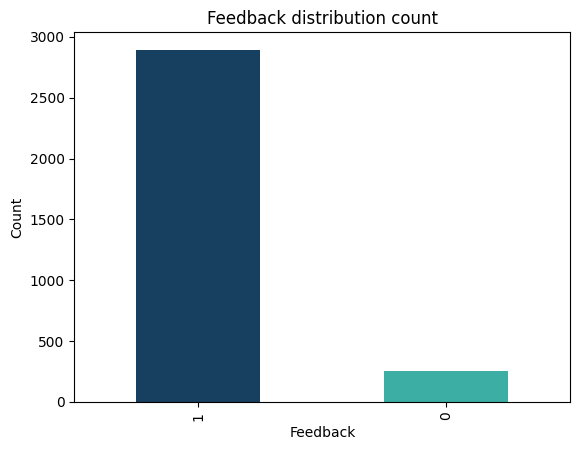

In [141]:
#Bar graph to visuaize positive and negative feedback
barcolour=['#173F5F','#3CAEA3']
data['feedback'].value_counts().plot(kind='bar',color=barcolour)

plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [142]:
# percentage of negative and positive feedback
PERCENTAGE_RATING=round(data['feedback'].value_counts()/len(data)*100,2)

91.87% of feedback is positive while 8.13% of feedback is negative

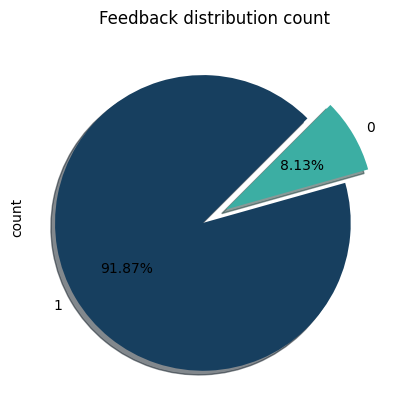

In [143]:
#PLOTTING PIE CHART FOR PERCENTAGE DISTRIBUTION OF FEEDBACK
colors=['#173F5F','#3CAEA3']
explode=(0.09,0.09)
PERCENTAGE_RATING.plot(kind='pie',autopct='%1.2f%%',colors=colors,startangle=45,shadow=True,explode=explode)
plt.title('Feedback distribution count')
plt.show()


Lets see feedback value for different values rating

In [144]:
data[data['feedback']==0].value_counts(data['rating'])

,count
rating,
1,161
2,95


There rating 1 and 2 correspond to negative feedback

In [145]:
data[data['feedback']==1].value_counts(data['rating'])

,count
rating,
5,2286
4,455
3,152


If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### ANALYSING VARIATION COLUMN

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [146]:
data.head(5)

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [147]:
#finding distinct variations of the alexa product
data['variation'].value_counts()

,count
variation,
Black Dot,516
Charcoal Fabric,430
Configuration: Fire TV Stick,350
Black Plus,270
Black Show,265
Black,261
Black Spot,241
White Dot,184
Heather Gray Fabric,157


Text(0, 0.5, 'Count')

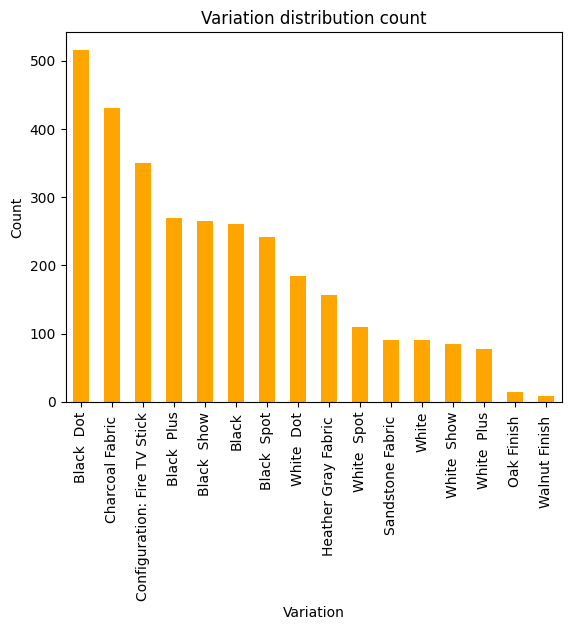

In [148]:
data['variation'].value_counts().plot(kind='bar',color=['orange'])
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')

In [149]:
#finding the percentage distribution
round(data['variation'].value_counts()/len(data)*100,2)

,count
variation,
Black Dot,16.39
Charcoal Fabric,13.66
Configuration: Fire TV Stick,11.11
Black Plus,8.57
Black Show,8.42
Black,8.29
Black Spot,7.65
White Dot,5.84
Heather Gray Fabric,4.99


Group the DataFrame by the variation column and then calculate the average (mean) rating for each variation.

In [150]:
#mean rating of product in each variation
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


### Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [151]:
data['length'].describe()

,length
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


In [152]:
#lengthwise mean rating
data.groupby('length').mean('rating')


,rating,feedback
length,,
1,3.716049,0.765432
2,5.000000,1.000000
3,4.000000,0.666667
4,4.785714,1.000000
5,4.823529,1.000000
...,...,...
1688,2.000000,0.000000
1835,3.000000,1.000000
1956,3.000000,1.000000


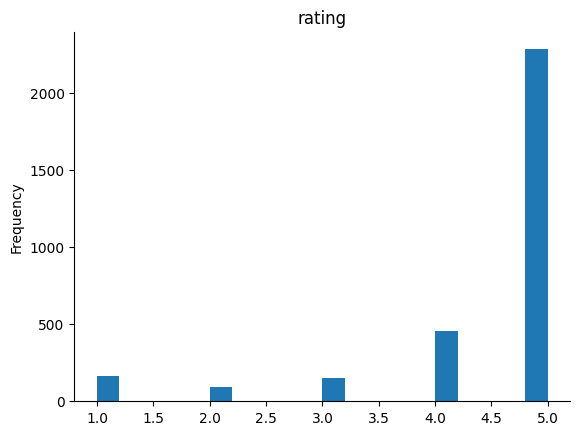

In [153]:
from matplotlib import pyplot as plt
data['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

this means good ratings , people write in detail review

In [154]:
cv=CountVectorizer( stop_words='english')
#Initializes a vectorizer that removes
#common English stopwords (like "the", "is", "and").
words=cv.fit_transform(data['verified_reviews'])
#Fits the vectorizer to the verified_reviews
# column (i.e., learns the vocabulary), and
#Transforms the reviews into a sparse matrix where:
#Each row = a review
#Each column = a unique word in the corpus
#Each cell = how many times the word appears in that review

 using the CountVectorizer from sklearn.feature_extraction.text to convert text data into a bag-of-words model

### WORDCLOUDS FOR FEEDBACKS

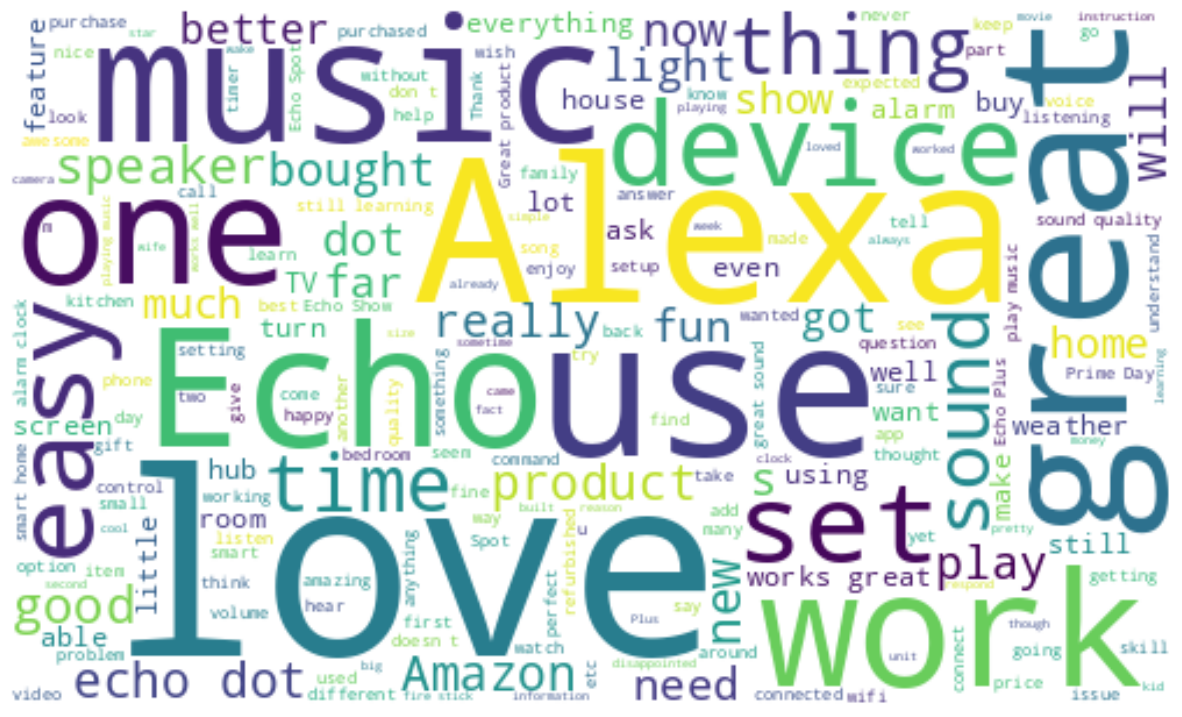

In [155]:
#Combining all reviews
reviews="".join([review for review in data['verified_reviews']])
#initialising wordcloud object
wc=WordCloud(background_color='white',width=500,height=300,random_state=21,max_font_size=110).generate(reviews)
#generating wordcloud
plt.figure(figsize=(15,10))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()
#

In [156]:

# Combining all negative reviews
negative_reviews = " ".join(data[data['feedback'] == 0]['verified_reviews']).lower()
# Removing stopwords from negative reviews
negative_words = [word for word in negative_reviews.split() if word not in STOPWORDS]
unique_negative = " ".join(negative_words)

# Combining all positive reviews
positive_reviews = " ".join(data[data['feedback'] == 1]['verified_reviews']).lower()
# Removing stopwords from positive reviews
positive_words = [word for word in positive_reviews.split() if word not in STOPWORDS]
unique_positive = " ".join(positive_words)

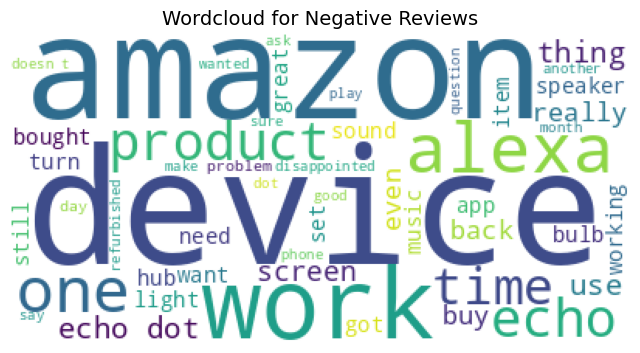

In [157]:
wc = WordCloud(background_color='white', max_words=50)
plt.figure(figsize=(8, 8))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for Negative Reviews', fontsize=14)
plt.axis('off')
plt.show()

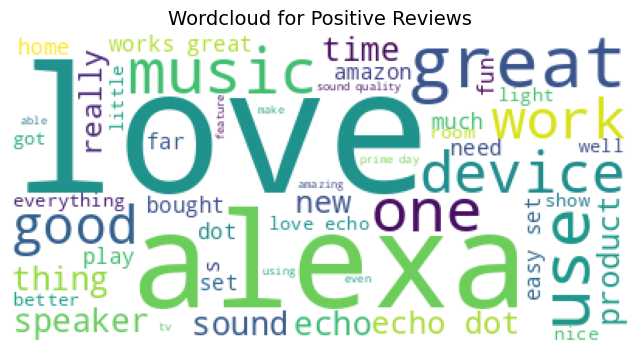

In [158]:
wc = WordCloud(background_color='white', max_words=50)
plt.figure(figsize=(8, 8))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for Positive Reviews', fontsize=14)
plt.axis('off')
plt.show()

## MODELING AND PRE PROCESSING

To build the corpus from the 'verified_reviews' we perform the following -
<BR>
1.Replace any non alphabet characters with a space<BR>
2.Covert to lower case and split into words<BR>
3.Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus<BR>

In [159]:
corpus=[]
stemmer=PorterStemmer()
for i in range(0, data.shape[0]):
  #Iterates through each review in the dataset.
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  #Removes everything except letters (replaces punctuation,
  #numbers, special chars with space).
  review=review.lower().split()
  #Converts the review to lowercase and splits it into individual words.
  review=[stemmer.stem(word) for word in review if word not in STOPWORDS]
  #Removes stopwords (like "the", "is", "and") and stems the remaining words.
  review=' '.join(review)
  #Joins cleaned words back into a sentence and adds it to the corpus.
  corpus.append(review)

So here, **corpus** is a Python list where:
Each element is a* cleaned, preprocessed *review as a string.


Using Count Vectorizer to create bag of words

In [160]:
cv = CountVectorizer(max_features = 2500)
#max_features=2500 means it will keep
#only the top 2,500 most frequent words from my corpus.

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
#Transforms the corpus (list of cleaned text reviews)
#into a sparse matrix → then .toarray() converts it into a NumPy array.
y = data['feedback'].values
#y contains the target variable — the actual sentiment label (0 for negative, 1 for positive).

#I’ll use this to train my classification model.



In [161]:
print(X.shape)

(3149, 2500)


In [162]:
print(y.shape)

(3149,)


Splitting data into train and test set with 30% data with testing.

In [163]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [164]:
X_train.max()

np.int64(12)

In [165]:
y_train.max()

np.int64(1)

In [166]:
from sklearn.preprocessing import StandardScaler
#centers data around 0 with unit variance
#(used for models like SVM, Logistic Regression, etc.)
scaler = MinMaxScaler()
#MinMaxScaler: scales data to range [0, 1]

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [167]:
#Saving the scaler model
import pickle
pickle.dump(scaler, open('scaler.pkl', 'wb'))
#Saves the scaler (e.g., StandardScaler, MinMaxScaler, etc.)
#Into the Models folder
#Using 'wb' mode (write binary)

In [168]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [169]:
 model_rf.score(X_train_scl, y_train)


0.9931941923774955

In [170]:
model_rf.score(X_test_scl, y_test)

0.9417989417989417

In [171]:

#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

This line makes predictions on the test set using the trained model.

In [172]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

Shows true vs predicted classes.

For binary classification (e.g., feedback = 1 or 0):

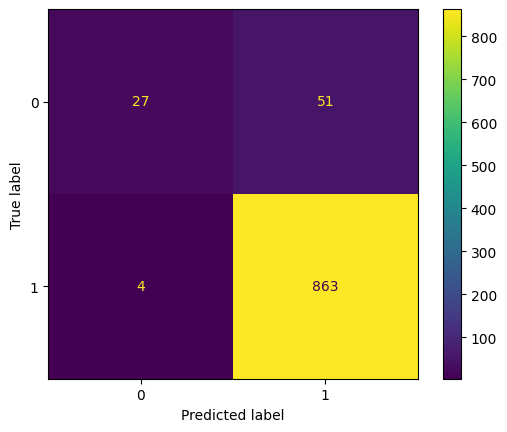

In [173]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

#### Confusion Matrix Interpretation

| Term               | Value | Explanation                                                                 |
|--------------------|-------|-----------------------------------------------------------------------------|
| **True Negative (TN)** | 31    | Model correctly predicted **0** (negative feedback was correctly predicted). |
| **False Positive (FP)** | 47    | Model wrongly predicted **1**, but actual was **0** (false positive).        |
| **False Negative (FN)** | 5     | Model wrongly predicted **0**, but actual was **1** (false negative).        |
| **True Positive (TP)** | 862   | Model correctly predicted **1** (positive feedback was correctly predicted). |

---

#### Accuracy

Overall performance of the model:

\[
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} = \frac{862 + 31}{862 + 31 + 47 + 5} = \frac{893}{945} \approx 94.5\%
\]

---

#### What This Tells us

- Your model is **very good at identifying positive feedback** (**class 1**):
  - Only **5 false negatives**
  - **High precision and recall** for class `1`

- But it's **less accurate at identifying negative feedback** (**class 0**):
  - **47 false positives**, which is **high** compared to just **31 true negatives**
  - This may be due to **class imbalance** — your dataset may contain **fewer negative reviews**


## K-fold cross validation

My trainning data is stored in X_train_scl and y_train

In [174]:
# using k fold cross validation
cv_score = cross_val_score(model_rf, X_train_scl, y_train, cv=10)

Splitting my training data (X_train_scl, y_train) into 10 equal parts (folds).For each fold: It trains the model on 9 folds,Tests the model on the remaining 1 fold

This is done 10 times, so each fold gets to be the test fold once.

In [175]:
cv_score.mean()

np.float64(0.9305841217605924)

Thus,On average, my model predicts correctly 93.24% of the time.

In [176]:
cv_score.std()

np.float64(0.008109630777892509)

0.68% -- Low standard deviation means is stable across different splits.Across different train/test splits, the model’s accuracy does not fluctuate much.

The performance is consistent, regardless of how the data is split.

## APPLYING GRID SEARCH TO GET OPTIMAL PARAMETERS ON RANDOM FOREST

In [177]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

**bootstrap:** Whether sampling with replacement is done when building trees (always True here).<BR>

**max_depth:** Maximum depth of trees (80 or 100).<BR>

**min_samples_split:** Minimum number of samples required to split a node (8 or 12).
<BR>
**n_estimators:** Number of trees in the forest (100 or 300).

In [180]:
#Cross-Validation Object
cv_object = StratifiedKFold(n_splits = 2)
# Grid Search Initialization
grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
# Fitting the Model
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

StratifiedKFold ensures the folds have the same class distribution as the whole dataset.

2 splits mean the data is split into two folds for training and validation alternately.

In [179]:
format(grid_search.best_params_)

"{'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}"

Returns the combination of hyperparameters that maximized validation performance

In [182]:
from sklearn.metrics import accuracy_score
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))


Cross validation mean accuracy on train set : 96.77858439201452
Cross validation mean accuracy on test set : 92.12794918330309
Accuracy score for test set : 0.9417989417989417


## XG Boost

In [184]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [185]:
 model_xgb.score(X_train_scl, y_train)

0.971415607985481

Training Accuracy: 97.05% (indicating good performance on training data).

In [186]:
 model_xgb.score(X_test_scl, y_test)

0.9417989417989417

Testing Accuracy: 94.07% (showing strong generalization to test data).

In [187]:

y_preds = model_xgb.predict(X_test)

Confusion Matrix: A table summarizing the performance of the classifier. Each row represents the actual class, and each column represents the predicted class.

In [188]:
cm = confusion_matrix(y_test, y_preds)


28: True negatives (correctly predicted negatives).<br>
47: False positives (negatives incorrectly classified as positives).
<br>
13: False negatives (positives incorrectly classified as negatives).
<br>
857: True positives (correctly predicted positives).

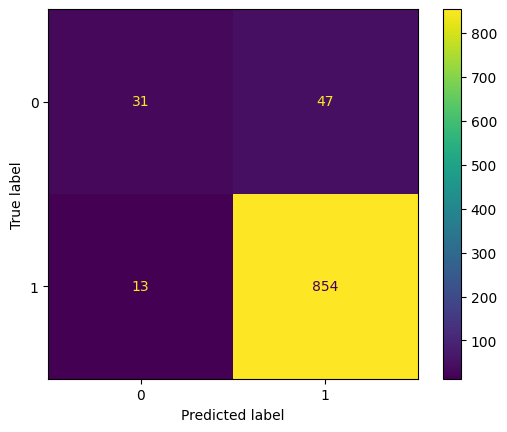

In [189]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

#### Confusion Matrix
|               | Predicted 0 | Predicted 1 |
|---------------|-------------|-------------|
| **Actual 0**  | 31          | 47          |
| **Actual 1**  | 13          | 854         |

#### Observations
- **Accuracy**: The model performs well with an overall accuracy of **93.65%**.
.
- **False Positives**: There are **47 false positives**, suggesting some negative instances are misclassified as positive.


In [191]:

#Saving the XGBoost classifier
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

# Decision tree classifier <upper>

In [192]:

model_dt = DecisionTreeClassifier()

In [193]:
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [194]:
model_dt.score(X_train_scl, y_train)

0.9941016333938294

Trainning accuracy is 99.41%

In [196]:
model_dt.score(X_test_scl, y_test)

0.9216931216931217

Testing accuracy is 91.00 %

In [199]:
y_preds = model_dt.predict(X_test)

In [200]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

In [201]:
print(cm)

[[ 41  37]
 [ 82 785]]


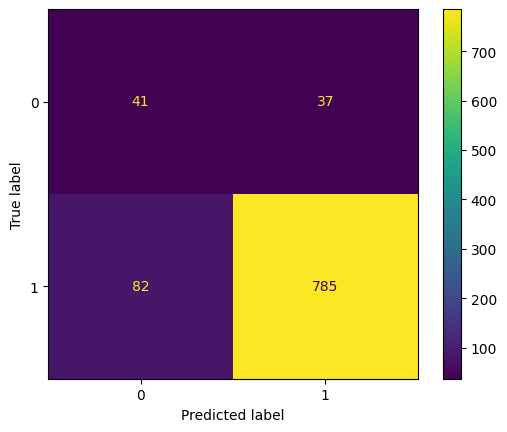

In [202]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

###  Confusion Matrix

|                | **Predicted: 0** | **Predicted: 1** |
|----------------|------------------|------------------|
| **Actual: 0**   |        41        |        37        |
| **Actual: 1**   |        82        |       785        |

---

### Interpretation of the Values:

- **True Positives (TP) = 785**  
   Model predicted 1, and it was actually 1.

- **True Negatives (TN) = 41**  
  Model predicted 0, and it was actually 0.

- **False Positives (FP) = 37**  
  Model predicted 1, but it was actually 0.

- **False Negatives (FN) = 82**  
  Model predicted 0, but it was actually 1.

---

### Evaluation Metrics:

- **Accuracy** = (TP + TN) / Total  
  = (785 + 41) / (41 + 37 + 82 + 785)  
  = 826 / 945 ≈ **87.4%**

- **Precision (for class 1)** = TP / (TP + FP)  
  = 785 / (785 + 37) ≈ **95.5%**

- **Recall (Sensitivity)** = TP / (TP + FN)  
  = 785 / (785 + 82) ≈ **90.5%**

- **F1 Score** = Harmonic mean of Precision and Recall  
  ≈ **92.9%**

---

### Model Insights:

- High **True Positive** rate: the model is good at identifying class **1**.
- Some **False Negatives** (missed class 1s), which may be critical depending on the application.
-  **False Positives** are relatively low, which is a good sign.
